# Renewable Energy GCPBBB Grid Connected Photo Sensor Project

This notebook implements the Machine Learning pipeline for optimizing renewable energy integration. 
It covers data generation (calibrated with Mendeley data), feature engineering, model training, and evaluation.

In [19]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report

# Add src to path to import modules
sys.path.append(os.path.abspath('../src'))

from data_loader import generate_synthetic_data, get_real_world_stats
from preprocessing import preprocess_features, prepare_datasets
from model import train_energy_predictor, train_balancing_classifier

# Ensure output directories exist
os.makedirs('../models', exist_ok=True)
os.makedirs('../output', exist_ok=True)

## 1. Data Generation (Calibrated)
We load real-world statistics from the Mendeley dataset to calibrate our synthetic data generation.

In [20]:
print("Loading Real-World Data for Calibration...")
# Note: We assume the notebook is running from 'notebooks/' so dataset is at '../dataset'
real_stats = get_real_world_stats('../dataset')

print("Generating calibrated synthetic data...")
# Generate 1 month of data
n_samples = 1440 * 30 
data = generate_synthetic_data(n_samples, real_stats=real_stats)
print(f"Generated {len(data)} samples.")
data.head()

Loading Real-World Data for Calibration...
Loading Mendeley data from ../dataset...
Derived Real-World Stats -- Peak Power: 215.71W, Mean V: 88.10V
Generating calibrated synthetic data...
Generated 43200 samples.


,Timestamp,Irradiance,Temperature,Grid_Consumption,Battery_SoC,Generated_Power
0,2023-01-01 00:00:00,27.125130,13.114497,1147.161023,50.000000,5.851136
1,2023-01-01 00:01:00,23.087063,11.507707,1240.019535,49.008985,4.980089
2,2023-01-01 00:02:00,0.000000,16.503817,1137.105234,47.871880,0.000000
3,2023-01-01 00:03:00,0.000000,11.391364,1149.158190,46.722721,0.000000
4,2023-01-01 00:04:00,145.770443,13.936226,1127.238540,47.167683,31.444006


## 2. Feature Engineering
We add time-based features and lag features to capture temporal dependencies.

In [21]:
print("Preprocessing data...")
data_processed = preprocess_features(data.copy())
print(f"Data shape after preprocessing: {data_processed.shape}")

Preprocessing data...
Data shape after preprocessing: (43185, 14)


## 3. Model Development

### 3.1 Energy Predictor (Random Forest)
Predicts the next step's Grid Consumption.

In [22]:
# Create target: Next step consumption
data_processed['Target_Consumption'] = data_processed['Grid_Consumption'].shift(-1)
data_reg = data_processed.dropna()

X_train_reg, X_test_reg, y_train_reg, y_test_reg, scaler_reg, feature_cols_reg = prepare_datasets(
    data_reg, 'Target_Consumption'
)

print("Training Grid Consumption Predictor...")
model_reg = train_energy_predictor(X_train_reg, y_train_reg)

# Evaluate
y_pred_reg = model_reg.predict(X_test_reg)
mae = mean_absolute_error(y_test_reg, y_pred_reg)
print(f"Grid Consumption MAE: {mae:.4f}")

# Save
joblib.dump(model_reg, '../models/energy_predictor.pkl')
joblib.dump(scaler_reg, '../models/scaler_reg.pkl')

Training Grid Consumption Predictor...
Grid Consumption MAE: 41.6433


['../models/scaler_reg.pkl']

### 3.2 Balancing Classifier (XGBoost)
Predicts the optimal battery action: 0 (Discharge), 1 (Hold), 2 (Charge).

In [23]:
# Define Balancing Logic (Labels)
def get_balancing_signal(row):
    generation = row['Irradiance'] * 0.2
    consumption = row['Grid_Consumption'] * 0.1
    soc = row['Battery_SoC']
    
    if soc < 20:
        return 2 # Charge (Priority)
    elif soc > 80:
        return 0 # Discharge (Priority)
    elif abs(generation - consumption) < 20: # Threshold for balance
        return 1 # Hold
    elif generation > consumption:
        return 2 # Charge (Excess energy)
    else:
        return 0 # Discharge (Deficit)

data_clf = data_processed.copy()
data_clf['Signal'] = data_clf.apply(get_balancing_signal, axis=1)

X_train_clf, X_test_clf, y_train_clf, y_test_clf, scaler_clf, feature_cols_clf = prepare_datasets(
    data_clf, 'Signal', is_classification=True
)

print("Training Balancing Signal Classifier...")
model_clf = train_balancing_classifier(X_train_clf, y_train_clf)

# Evaluate
y_pred_clf = model_clf.predict(X_test_clf)
acc = accuracy_score(y_test_clf, y_pred_clf)
print(f"Balancing Classifier Accuracy: {acc:.4f}")
print(classification_report(y_test_clf, y_pred_clf))

# Save
joblib.dump(model_clf, '../models/balancing_classifier.pkl')
joblib.dump(scaler_clf, '../models/scaler_clf.pkl')

Training Balancing Signal Classifier...


/Users/nisaljinadasa/Documents/Coding/ML Project/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [09:06:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Balancing Classifier Accuracy: 0.9988
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5185
           1       0.98      0.98      0.98       152
           2       1.00      1.00      1.00      3300

    accuracy                           1.00      8637
   macro avg       0.99      0.99      0.99      8637
weighted avg       1.00      1.00      1.00      8637



['../models/scaler_clf.pkl']

## 4. Visualization
Visualize the predictions and system behavior.

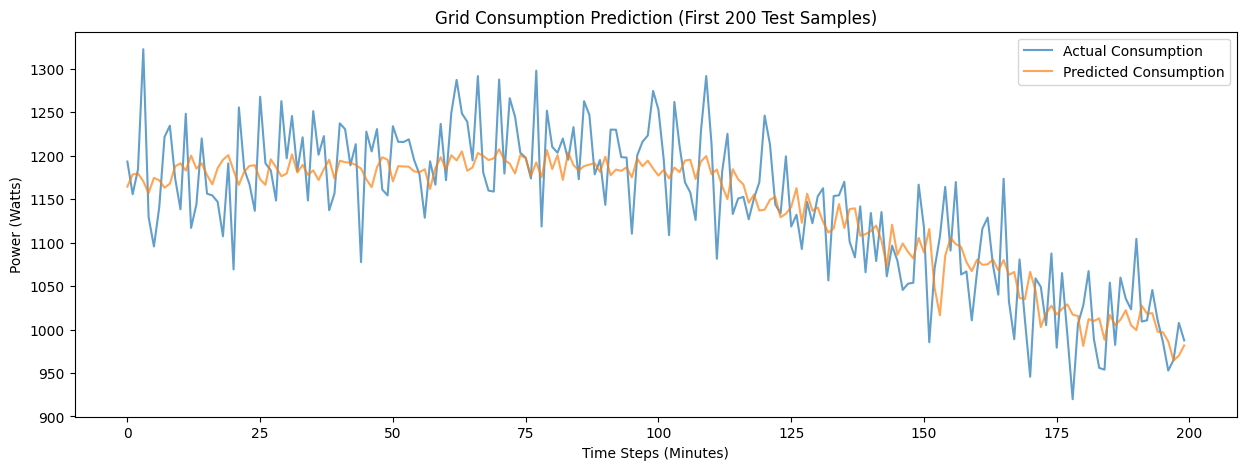

In [24]:
plt.figure(figsize=(15, 5))
plt.plot(y_test_reg.values[:200], label='Actual Consumption', alpha=0.7)
plt.plot(y_pred_reg[:200], label='Predicted Consumption', alpha=0.7)
plt.title('Grid Consumption Prediction (First 200 Test Samples)')
plt.xlabel('Time Steps (Minutes)')
plt.ylabel('Power (Watts)')
plt.legend()
plt.show()